In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from scipy.ndimage import rotate
import time
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from tqdm.auto import tqdm
from torchvision.transforms import v2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        # Load the data
        self.data = pd.read_csv(csv_file)

    def __getitem__(self, index):
        # Get the data for one example
        example_data = self.data.iloc[index]
        # Separate the features from the target
        features = torch.tensor(example_data[2:].values, dtype=torch.float32).reshape(1, 28, 28)
        target = torch.tensor(example_data.iloc[1], dtype=torch.long)
        return features, target

    def __len__(self):
        return len(self.data)
    
    def classes(self, index):
        return self.data.iloc[index].iloc[1]


# Create instances of the dataset
train_data = CSVDataset('final_dataset/train_dataset.csv')
test_data = CSVDataset('final_dataset/test_dataset.csv')


In [5]:
image, label = train_data[1134]
label.item(), image.shape

(9, torch.Size([1, 28, 28]))

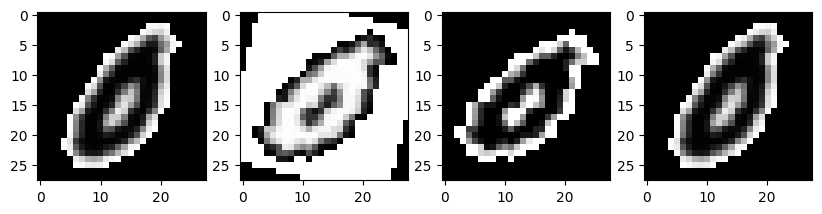

In [6]:
number = random.randint(0,len(train_data))

image, label = train_data[number]

augmenter = v2.AutoAugment(v2.AutoAugmentPolicy.SVHN)

imgs = [[augmenter(F.to_pil_image(image)) for _ in range(4)]]

fig, axs = plt.subplots(1, 4, figsize=(10, 10))  # Create a subplot with 1 row and 4 columns
for i, img in enumerate(imgs[0]):  # Loop over the augmented images
    axs[i].imshow(np.array(img).squeeze(), cmap='gray')  # Plot the image
plt.show()


# plt([[imgs] + row for row in imgs], row_title="first_try")

> We can see that augmentation works but a random version is not viable. We are using only grayscale images so we should focus more on rotation and flipping kind of augmentations.

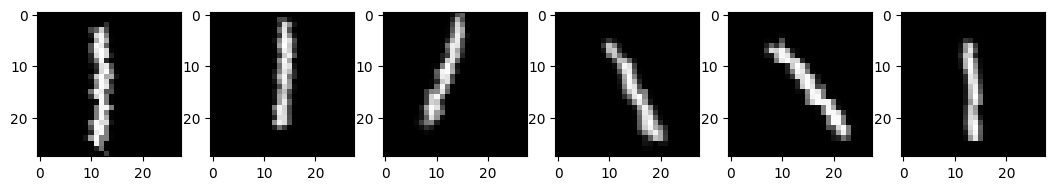

In [7]:
number = random.randint(0,len(train_data))

image, label = train_data[number]

transforms = v2.Compose([v2.RandomCrop(size = (28, 28), padding=(3,3)),
                         v2.RandomRotation(degrees=25),
                         v2.RandomAffine(degrees=20),
                         v2.RandomPerspective(distortion_scale=0.34)])

imgs = [[transforms(image) for _ in range(6)]]


fig, axs = plt.subplots(1, 6, figsize=(13, 13))  # Create a subplot with 1 row and 4 columns
for i, img in enumerate(imgs[0]):  # Loop over the augmented images
    axs[i].imshow(np.array(img).squeeze(), cmap='gray')  # Plot the image
plt.show()

In [10]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transforms):
        self.original_dataset = original_dataset
        self.transforms = transforms

    def __getitem__(self, index):
        img, label = self.original_dataset[index]
        return self.transforms(img), label

    def __len__(self):
        return len(self.original_dataset)


In [11]:
augmented_train_data = AugmentedDataset(train_data, transforms)

In [12]:
classes_list = set()
for i in range(len(test_data)):
    _, target = test_data[i]
    classes_list.add(target.item())

classes_list

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61}

In [13]:
len(classes_list)

62

In [14]:
BATCH_SIZE = 16

combined_train_data = ConcatDataset([train_data, augmented_train_data])

train_dataloader = DataLoader(combined_train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 46113 iterations with the batch size of 16.
For testing data there is 3901 iterations with the batch size of 16.


In [15]:
# Create a convolutional neural network
class LetterRecognizerModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.Dropout(0.25)  # Dropout added here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)  # Dropout added here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=128),  # Additional dense layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(in_features=128,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_0 = LetterRecognizerModel0(input_shape=1,
    hidden_units=10,
    output_shape=len(classes_list)).to(device)
model_0

LetterRecognizerModel0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=62, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.001)

In [17]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [18]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [19]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [20]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_0 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 20
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_0 = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_model_0,
                                           end=train_time_end_model_0,
                                           device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss is:1.85773, Train accuracy is:50.06%
Test loss is:0.835409, Test accuracy is:75.052871%
Epoch: 0
---------
Train loss is:0.79517, Train accuracy is:75.77%
Test loss is:0.672366, Test accuracy is:79.097347%
Epoch: 1
---------
Train loss is:0.68912, Train accuracy is:77.83%
Test loss is:0.558802, Test accuracy is:79.778903%
Epoch: 2
---------
Train loss is:0.61304, Train accuracy is:78.54%
Test loss is:0.544016, Test accuracy is:80.120161%
Epoch: 3
---------
Train loss is:0.59454, Train accuracy is:79.02%
Test loss is:0.541636, Test accuracy is:79.888170%
Epoch: 4
---------
Train loss is:0.58312, Train accuracy is:79.33%
Test loss is:0.532367, Test accuracy is:80.261471%
Epoch: 5
---------
Train loss is:0.57296, Train accuracy is:79.55%
Test loss is:0.527935, Test accuracy is:80.236798%
Epoch: 6
---------
Train loss is:0.56654, Train accuracy is:79.79%
Test loss is:0.516860, Test accuracy is:80.855870%
Epoch: 7
---------
Train loss is:0.56085, Train accuracy is:79.94%
Test los

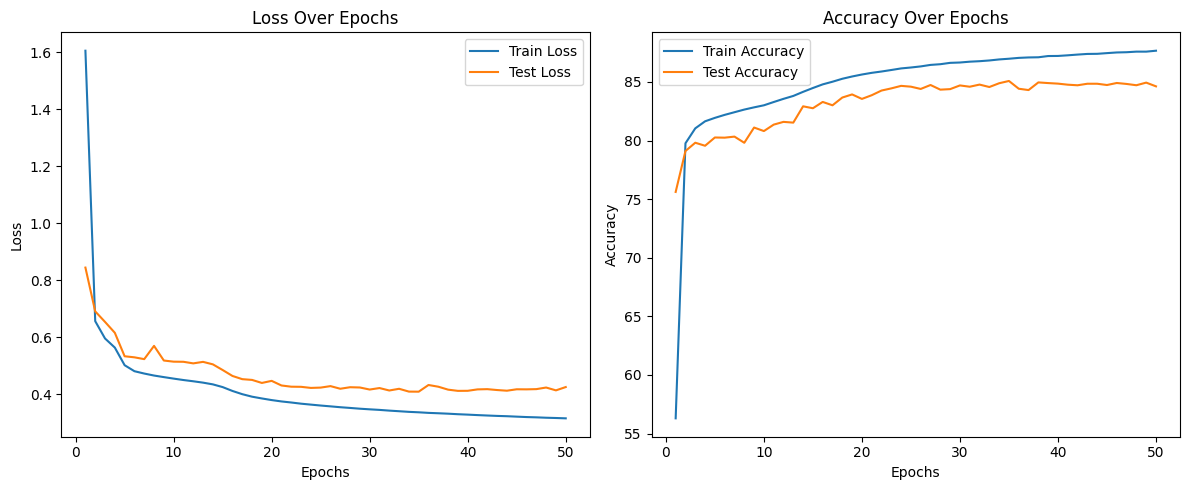

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

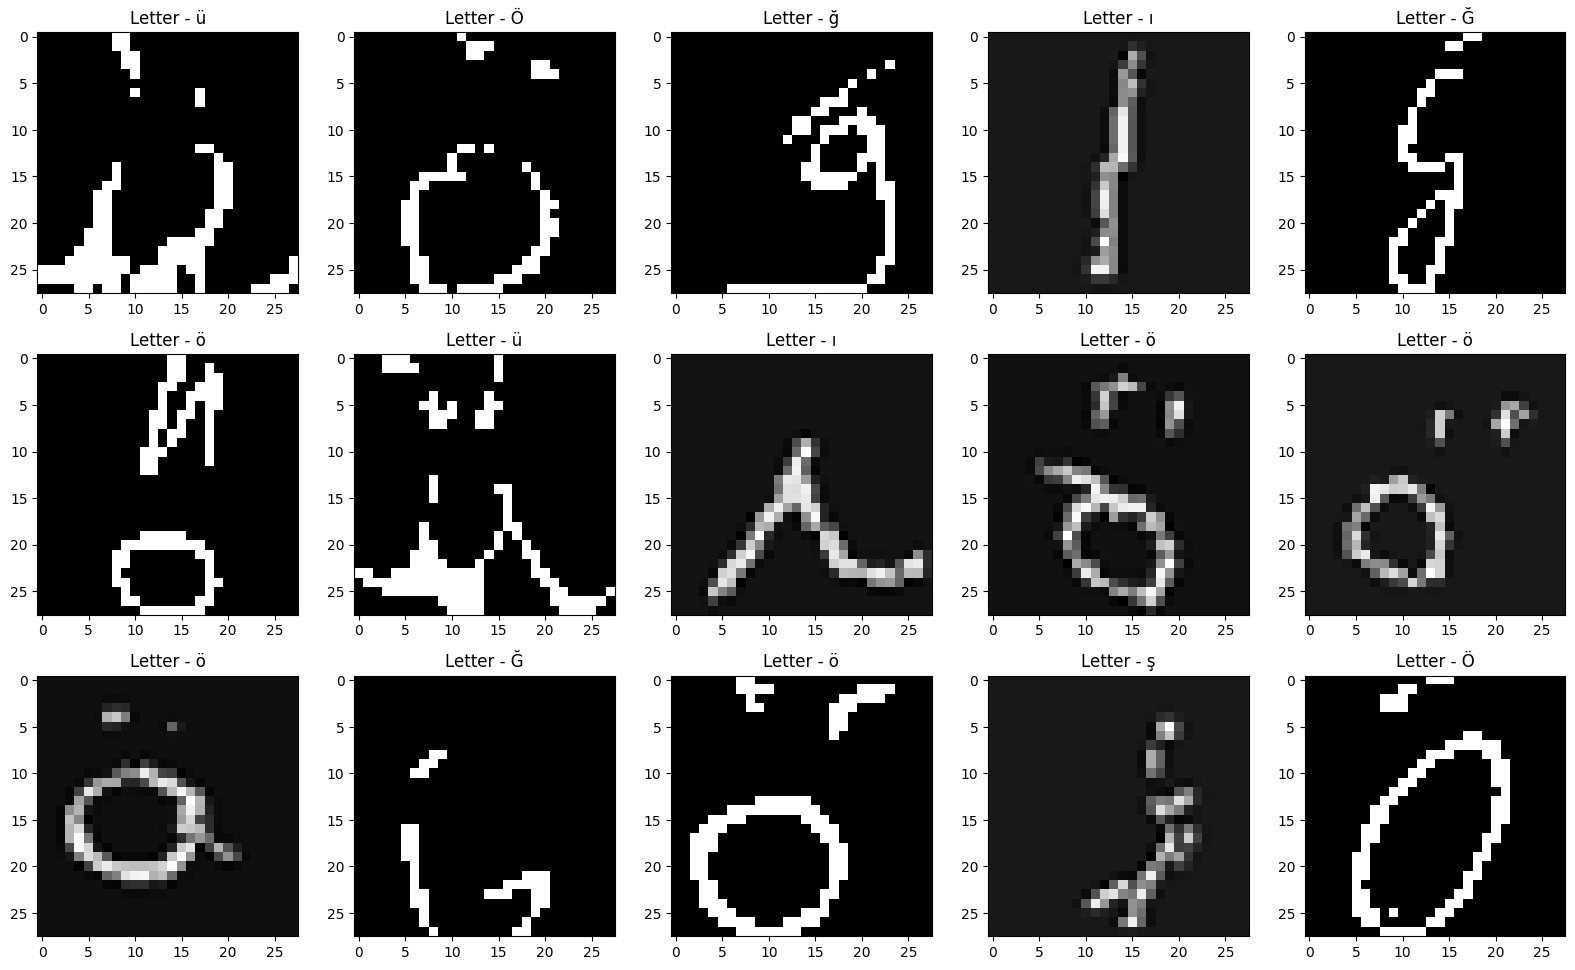

In [5]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        random_class = random.choice(list(mapping.keys()))
        filtered_train = train[train[first_column_name] == random_class]
        random_row = filtered_train.sample()    
        pixels = np.array(random_row.iloc[0])
        pixels = pixels[1:]
        image = pixels.reshape(28, 28)
        image = image.T
        plt.subplot(5, 5,idx+1)
        plt.imshow(image, cmap = mono)
        plt.title(f"Letter - {mapping[random_class]}")
        
    plt.tight_layout()
    
Show_example_digits()

Class 0 (0): 34585
Class 1 (1): 38374
Class 2 (2): 34203
Class 3 (3): 35143
Class 4 (4): 33535
Class 5 (5): 31416
Class 6 (6): 34232
Class 7 (7): 35754
Class 8 (8): 33946
Class 9 (9): 33847
Class 10 (A): 6407
Class 11 (B): 3878
Class 12 (C): 10094
Class 13 (D): 4562
Class 14 (E): 4934
Class 15 (F): 9182
Class 16 (G): 2517
Class 17 (H): 3152
Class 18 (I): 11946
Class 19 (J): 3762
Class 20 (K): 2468
Class 21 (L): 5076
Class 22 (M): 9002
Class 23 (N): 8237
Class 24 (O): 24983
Class 25 (P): 8347
Class 26 (Q): 2605
Class 27 (R): 5073
Class 28 (S): 20764
Class 29 (T): 9820
Class 30 (U): 12602
Class 31 (V): 4637
Class 32 (W): 4695
Class 33 (X): 2771
Class 34 (Y): 4743
Class 35 (Z): 2701
Class 36 (a): 10033
Class 37 (b): 5159
Class 38 (c): 2854
Class 39 (d): 10177
Class 40 (e): 24631
Class 41 (f): 2561
Class 42 (g): 3687
Class 43 (h): 8738
Class 44 (i): 2725
Class 45 (j): 1896
Class 46 (k): 2491
Class 47 (l): 15318
Class 48 (m): 2645
Class 49 (n): 11418
Class 50 (o): 2749
Class 51 (p): 2448
Cl

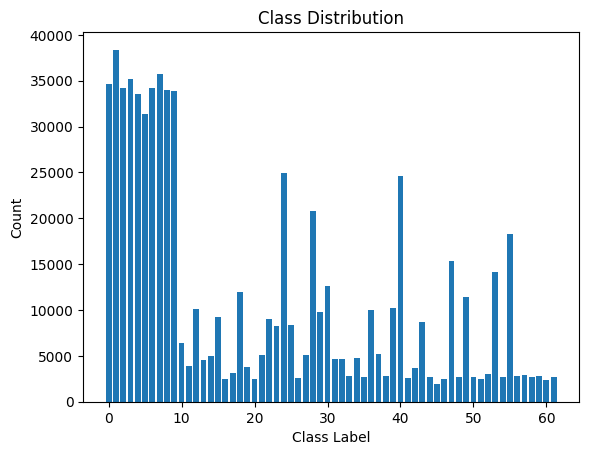

In [69]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of instances per class
class_counts = Counter([train_data[i][1] for i in range(len(train_data))])

# Print the class counts
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label} ({train_data.classes[class_label]}): {count}")

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [19]:
print(torch.cuda.device_count())
torch.cuda.get_device_name()

1


'NVIDIA GeForce RTX 2060'

In [72]:
# CPU
start_time = time.time()
a = torch.ones(4,4)
for _ in range(1000000):
    a += a
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

# GPU
start_time = time.time()
b = torch.ones(4,4).cuda()
for _ in range(1000000):
    b += b
elapsed_time = time.time() - start_time
print('GPU time = ',elapsed_time)

CPU time =  1.7860863208770752
GPU time =  18.131277799606323


The GPU’s strength comes from its ability to perform many operations in parallel, so it’s generally more efficient for complex operations or large data sizes1. However, in your case, the operation is quite simple (just addition), and the size of the tensor is small (only 4x4). This means there’s not much opportunity for parallelization, which is why the GPU might not be faster than the CPU1.

In addition, there’s some overhead when transferring data between the CPU and the GPU. If the computation time is small compared to this overhead, then the GPU can end up being slower than the CPU1.

Another factor could be the data type. GPUs are mostly optimized for operations on 32-bit floating numbers. If you’re using a different data type (like double), the GPU might be slower2.

Finally, the first CUDA call in a program is slow because it involves initializing the CUDA context1. If your program only makes a few CUDA calls, this initialization overhead can make the GPU slower than the CPU1.